1º) iteración:
- Eliminar a mano outliers de Fare (Esos tres de 500)
- Inputar dos pasajeros con Embarked a null
- Seguimos ignorando age
- Eliminar SibSp y Parch (Viendo el correlation heatmap no estan correlacionadas con Survived) \
 Resultados: 0.77272 (Mejoró)

2º) Iteración
- Eliminamos Pclass (Está muy relacionada con Fare) \
 Resultados: 0.75837 (Empeoró)

3º) Iteración
- Volvemos a poner Pclass
- Quitamos Fare \
 Resultados: 0.77751 (Mejor hasta ahora) ¿Porqué paso esto?

4º) Iteración
- Quitamos embarked Empeoró

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [282]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [283]:
train = train.loc[train['Fare'] < 500]

In [284]:
train['Embarked'] = train['Embarked'].fillna('Q')

In [285]:
# Missing value in test
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [286]:
train['Sex'] = train['Sex'].map({"male": 0, "female": 1})
train['Embarked'] = train['Embarked'].map({"C": 0, "Q": 1, "S": 2})

test['Sex'] = test['Sex'].map({"male": 0, "female": 1})
test['Embarked'] = test['Embarked'].map({"C": 0, "Q": 1, "S": 2})

In [287]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  888 non-null    int64  
 1   Survived     888 non-null    int64  
 2   Pclass       888 non-null    int64  
 3   Name         888 non-null    object 
 4   Sex          888 non-null    int64  
 5   Age          711 non-null    float64
 6   SibSp        888 non-null    int64  
 7   Parch        888 non-null    int64  
 8   Ticket       888 non-null    object 
 9   Fare         888 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     888 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 90.2+ KB


In [288]:
passengerid_test = test['PassengerId'].values.tolist()

In [289]:
train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [290]:
train_fe = train.copy(deep=True)
test_fe = test.copy(deep=True)

In [ ]:
train_fe.drop(columns=['Age', 'Parch', 'SibSp', 'Fare'], inplace=True)
test_fe.drop(columns=['Age', 'Parch', 'SibSp', 'Fare'], inplace=True)

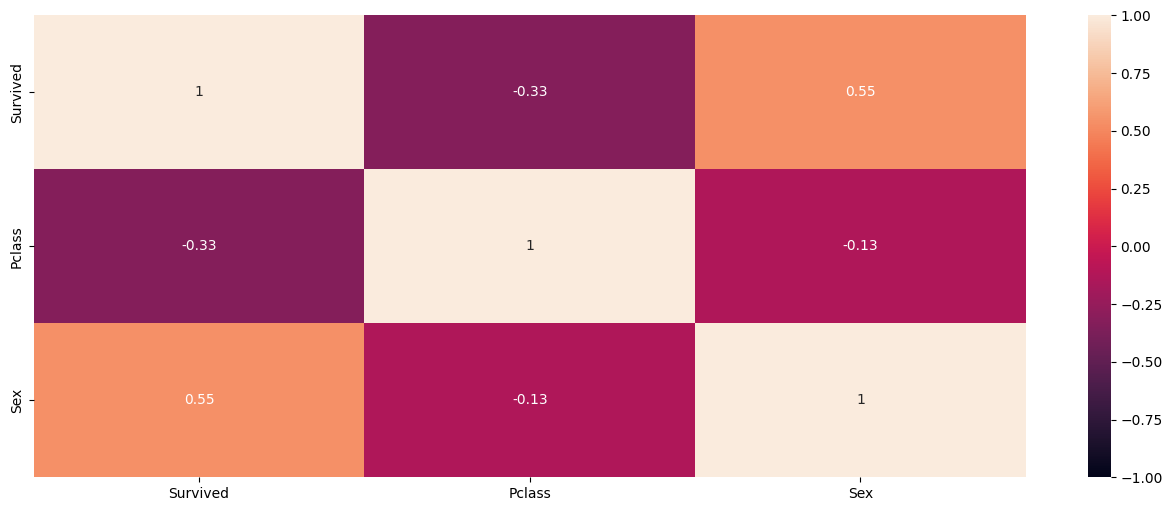

In [292]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_fe.corr(), vmin=-1, vmax=1, annot=True)

In [293]:
def remove_outliers_iqr(df, columns):
    for column in columns: 
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [294]:
#train_fe = remove_outliers_iqr(train_fe, ['Fare'])

In [295]:
scaler = MinMaxScaler()

In [296]:
columns_to_normalize = ['Fare']

In [297]:
# Min_max to normalize the quantitative variables (continuous and discrete)
#train_fe[columns_to_normalize] = scaler.fit_transform(train_fe[columns_to_normalize])

#test_fe[columns_to_normalize] = scaler.fit_transform(test_fe[columns_to_normalize])

In [298]:
train_fe = pd.get_dummies(train_fe, columns=[ 'Pclass'])

test_fe = pd.get_dummies(test_fe, columns=['Pclass'])

In [299]:
# Change boolean columns to integers
bool_cols = train_fe.select_dtypes(include='bool').columns
train_fe[bool_cols] = train_fe[bool_cols].astype(int)

bool_cols = test_fe.select_dtypes(include='bool').columns
test_fe[bool_cols] = test_fe[bool_cols].astype(int)

In [300]:
train_fe = train_fe.astype(float)

test_fe = test_fe.astype(float)

In [301]:
train_fe.head(10)

,Survived,Sex,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0
8,1.0,1.0,0.0,0.0,1.0
9,1.0,1.0,0.0,1.0,0.0


In [302]:
test_fe.head(10)

,Sex,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0
5,0.0,0.0,0.0,1.0
6,1.0,0.0,0.0,1.0
7,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0


In [303]:
X = train_fe.drop('Survived', axis=1).to_numpy() # Features
y = train_fe['Survived'].to_numpy() # Labels

In [304]:
# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # use long for classification with nn.CrossEntropyLoss

# Wrap into a TensorDataset
# Create a DataLoader
train_dataloader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

In [305]:
# Neural Network Definition
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout_rate=0.3):
        super(TitanicNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x
    
# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_X, batch_y in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            batch_y = batch_y.unsqueeze(1)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    return train_losses, train_accuracies

In [306]:
# Initialize model
input_size = X.shape[1]
model = TitanicNN(input_size=input_size)

In [307]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")

# Train the model
train_losses, train_accuracies = train_model(model, train_dataloader, criterion, optimizer, num_epochs=300)

Starting training...
Epoch [20/300], Loss: 0.4666, Accuracy: 0.7703
Epoch [40/300], Loss: 0.4649, Accuracy: 0.7770
Epoch [60/300], Loss: 0.4523, Accuracy: 0.7950
Epoch [80/300], Loss: 0.4563, Accuracy: 0.7962
Epoch [100/300], Loss: 0.4483, Accuracy: 0.7939
Epoch [120/300], Loss: 0.4633, Accuracy: 0.7815
Epoch [140/300], Loss: 0.4536, Accuracy: 0.7894
Epoch [160/300], Loss: 0.4518, Accuracy: 0.7995
Epoch [180/300], Loss: 0.4618, Accuracy: 0.7894
Epoch [200/300], Loss: 0.4566, Accuracy: 0.7872
Epoch [220/300], Loss: 0.4504, Accuracy: 0.7973
Epoch [240/300], Loss: 0.4631, Accuracy: 0.7827
Epoch [260/300], Loss: 0.4602, Accuracy: 0.7905
Epoch [280/300], Loss: 0.4607, Accuracy: 0.7793
Epoch [300/300], Loss: 0.4484, Accuracy: 0.7905


In [308]:
outputs = model(torch.tensor(test_fe.to_numpy(), dtype=torch.float32))

In [309]:
outputs = [int(round(x, 0)) for x in np.array(outputs.tolist()).flatten().tolist()] 

In [310]:
df_output = pd.DataFrame({'PassengerId': passengerid_test ,'Survived': outputs})

In [311]:
df_output.to_csv('output.csv', index=False)